<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 5
*Fit splines into single features in your project data. Explore options to obtain the best fit.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing)

In [1423]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy import interpolate
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")

from matplotlib.pyplot import figure
from numpy.random import normal
import numpy as np

## Interpolación spline en datos de demanda eléctrica
Aplicaremos el ajuste splines a datos de demanda eléctrica en una región en México. 

Queremos probar el uso de splines en interpolación de datos perdidos. La serie original está completa y borraremos algunos datos aleatoriamente. Después los completaremos usando interpolación spline de primer hasta quinto orden y compararemos su desempeño con el error absoluto medio **Mean Absolute Error (MAE)**.


In [1424]:
df = pd.read_csv('demanda.csv')

In [1425]:
## Guardamos los datos originales para después compararlos con los datos interpolados.
df    = df[['Y']]
aux   = np.arange(len(df))
dfx   = pd.DataFrame(aux)
dfy   = df 
n     = len(dfx)

In [1426]:
## De la serie original borramos algunos datos aleatoriamente.
r = round( len(df) * 0.2 )
np.random.seed(0)
random = []
for i in range(r):
    random.append(np.random.randint(0,len(df)))
notmiss = []
for i in random:
    if i not in notmiss:
        notmiss.append(i)

df_notmiss  = df
dfy_notmiss = df_notmiss.drop( index = notmiss )

dfx_notmiss = dfx
dfx_notmiss = dfx_notmiss.drop( index = notmiss )

In [1427]:
x = dfx_notmiss
y = dfy_notmiss

In [1428]:
def spline_by_order_k(x, y, dfx, dfy, k):
   for item in range(len(k)):
       tck  = interpolate.splrep(x, y, k=k[item])
       xor  = np.arange(0, n-1, 1/50)
       yor  = interpolate.splev(xor, tck)
       xspline.append( xor )
       yspline.append( yor )

       ## Comparamos contra los datos originales usando el MAE
       y_or   = interpolate.splev(dfx, tck) ## Esta variable se usará para comparar contra el original
       err_or = mean_absolute_error(dfy,y_or)
       print('!order:', k[item],'| mae',err_or,'|')

k = [1,2,3,4,5]
xspline = []
yspline = []
spline_by_order_k(x, y, dfx, dfy, k)

!order: 1 | mae 10.858136422743053 |
!order: 2 | mae 10.810026975929235 |
!order: 3 | mae 11.160054735682339 |
!order: 4 | mae 13.05159952895415 |
!order: 5 | mae 13.868068418630621 |


No handles with labels found to put in legend.


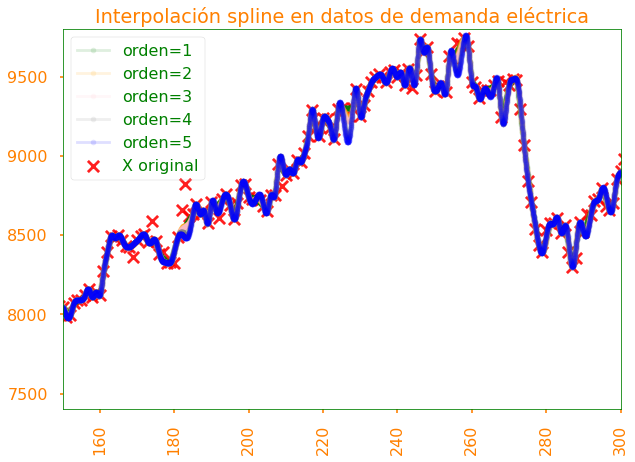

In [1429]:
fig  = plt.figure(figsize=(10,7))
axes = fig.add_subplot(1, 1, 1)
plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'
mytitle = plt.title('Interpolación spline en datos de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color='#ff8000')                                        #set the color of title to red
axes.xaxis.label.set_color('#ff8000')
axes.yaxis.label.set_color('#ff8000')
axes.tick_params(   colors='#ff8000', which='both')

plt.scatter( dfx, dfy,         marker='x'  , color = 'red'    , label = 'X original'        ,alpha=7/8)
axes.plot  ( xspline[0], yspline[0] , '.-'  , color = 'green'  , label = 'orden=1'  ,alpha=1/8)
axes.plot  ( xspline[1], yspline[1] , '.-'  , color = 'orange' , label = 'orden=2'  ,alpha=1/8)
axes.plot  ( xspline[2], yspline[2] , '.-'  , color = 'pink'   , label = 'orden=3'  ,alpha=1/8)
axes.plot  ( xspline[3], yspline[3] , '.-'  , color = 'gray'   , label = 'orden=4'  ,alpha=1/8)
axes.plot  ( xspline[4], yspline[4] , '.-'  , color = 'blue'   , label = 'orden=5'  ,alpha=1/8)

plt.axis([-5, 150, 7400, 9800])
plt.axis([150, 300, 7400, 9800])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda1.png', transparent=True)
#plt.legend(['Linear', 'Cubic Spline'])  
plt.show()

## Interpolación spline en series de tiempo de aportaciones en embalses
Ahora, haremos un ejemplo con datos de una serie de tiempo de aportaciones (lluvias) en el embalse (presa) Manuel Moreno Torres (MMT) una de las principales centrales hidroeléctricas en el país, ubicada en Chiapas, México. 

Queremos probar el uso de splines en interpolación de datos perdidos. La serie original está completa y borraremos algunos datos aleatoriamente. Después los completaremos usando interpolación spline de primer hasta quinto orden y compararemos su desempeño con el error absoluto medio **Mean Absolute Error (MAE)**.

In [1430]:
## Leemos y guardamos los datos originales
df  = pd.read_csv('Aportaciones_Embalses.csv')
df  = df.dropna() ## remove all lines with missing observations
dfx = df['x']
reservoir=['MMT'] ## Solo tomaremos Peñitas pero podría ser cualquiera de los demás embalses
dfy = df[reservoir] 
n = len(dfx)

In [1431]:
## De la serie original borramos algunos datos aleatoriamente.
r = round(len(df) * 0.2 )
np.random.seed(20)
random = []
for i in range(r):
    random.append(np.random.randint(0,len(df)))
notmiss = []
for i in random:
    if i not in notmiss:
        notmiss.append(i)

df_notmiss = df
df_notmiss = df_notmiss.drop( index = notmiss )

dfx_notmiss = df_notmiss['x']  
dfy_notmiss = df_notmiss[reservoir]

In [1432]:
x = dfx_notmiss
y = dfy_notmiss

In [1433]:
k=[1,2,3,4,5]
xspline = []
yspline = []
spline_by_order_k(x, y, dfx, dfy, k)

!order: 1 | mae 13.514445147679325 |
!order: 2 | mae 16.483435212498687 |
!order: 3 | mae 17.41336436565628 |
!order: 4 | mae 20.924869724139153 |
!order: 5 | mae 22.292357143929316 |


No handles with labels found to put in legend.


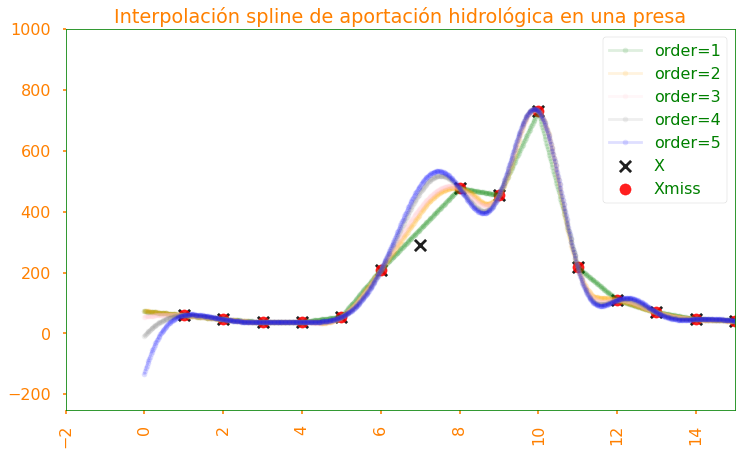

In [1434]:
fig  = plt.figure(figsize=(12,7))
axes = fig.add_subplot(1, 1, 1)
plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'
mytitle = plt.title('Interpolación spline de aportación hidrológica en una presa') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color='#ff8000')                                        #set the color of title to red
axes.xaxis.label.set_color('#ff8000')
axes.yaxis.label.set_color('#ff8000')
axes.tick_params(   colors='#ff8000', which='both')

plt.scatter( dfx, dfy,                marker='x'  ,  color = 'black'    , label = 'X'        ,alpha=7/8)
plt.scatter( dfx_notmiss,dfy_notmiss, marker='o'  ,  color = 'red'  , label = 'Xmiss'        ,alpha=7/8)
axes.plot  ( xspline[0], yspline[0] , '.-', color = 'green'  , label = 'order=1'  ,alpha=1/8)
axes.plot  ( xspline[1], yspline[1] , '.-', color = 'orange' , label = 'order=2'  ,alpha=1/8)
axes.plot  ( xspline[2], yspline[2] , '.-', color = 'pink'   , label = 'order=3'  ,alpha=1/8)
axes.plot  ( xspline[3], yspline[3] , '.-', color = 'gray'   , label = 'order=4'  ,alpha=1/8)
axes.plot  ( xspline[4], yspline[4] , '.-', color = 'blue'   , label = 'order=5'  ,alpha=1/8)

plt.axis([ -2, 15, -250, 1000])
#plt.axis([100, 200, -250, 1500])
#plt.axis([200, 400, -250, 1500])
#plt.axis([400, 600, -250, 1500])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('splineEmbalse0.png', transparent=True)
#plt.legend(['Linear', 'Cubic Spline'])  
plt.show()

### Ligas usadas en este apartado de splines

[Spline Interpolation Example in Python](https://www.datatechnotes.com/2021/11/spline-interpolation-example-in-python.html)

[Creating and Plotting Cubic Splines in Python](https://www.analytics-link.com/post/2018/08/17/creating-and-plotting-cubic-splines-in-python)


[B-spline Curve Fitting Example in Python](https://www.datatechnotes.com/2021/11/b-spline-fitting-example-in-python.html)

[documentación scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)